In [63]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft
import os
import pandas as pd
import librosa

SEGMENT_SIZE = 500 # millisecond
HOPPING = 1 # 100% HOPPING, 0 overlapping. for feature extraction

In [116]:
y, sr = librosa.load('../audio/dashahe.wav', sr=None)
mfcc = librosa.feature.mfcc(y=y, sr=sr)
bounds = librosa.segment.agglomerative(mfcc, 20)
bound_times = librosa.frames_to_time(bounds, sr=sr)
bound_samples = librosa.frames_to_samples(bounds)
print(bound_times)
print(bound_samples)

[ 0.          0.08533333  3.54133333  7.84       10.54933333 12.16
 18.89066667 19.34933333 25.26933333 25.76       28.29866667 28.33066667
 32.704      36.72533333 36.928      37.93066667 40.78933333 49.248
 59.12533333 63.33866667]
[      0    4096  169984  376320  506368  583680  906752  928768 1212928
 1236480 1358336 1359872 1569792 1762816 1772544 1820672 1957888 2363904
 2838016 3040256]


In [113]:
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
bounds = librosa.segment.agglomerative(chroma, 20)
bound_times = librosa.frames_to_time(bounds, sr=sr)
bound_samples = librosa.frames_to_samples(bounds)
print(bound_times)

[ 0.          3.456       7.22133333 12.21333333 19.82933333 23.744
 26.144      27.40266667 29.14133333 34.54933333 38.048      40.8
 42.66666667 44.55466667 46.41066667 55.66933333 60.20266667 67.392
 68.096      69.376     ]


In [117]:
i = -1

In [120]:
import IPython.display as ipd
if(i < len(bounds)): i += 1
## segments
print(f'Segment {i}')
print(f'{bound_times[i]} to {bound_times[i+1]}')
ipd.Audio(data=y[bound_samples[i]:bound_samples[i+1]], rate=sr)

Segment 2
3.541333333333333 to 7.84


In [122]:
onsets = librosa.onset.onset_detect(y=y, sr=sr)
onset_times = librosa.frames_to_time(onsets, sr=sr)
onset_samples = librosa.frames_to_samples(onsets)

In [124]:
i = -1

In [132]:
import IPython.display as ipd
if(i < len(onsets)): i += 1
## segments
print(f'Onset {i}')
print(f'{onset_times[i]} to {onset_times[i+1]}')
ipd.Audio(data=y[onset_samples[i]:onset_samples[i+1]], rate=sr)

Onset 7
11.968 to 13.877333333333333


# Foote's novelty segmentation

Calculate a self-similarity matrix given a feature sequence

https://www.audiolabs-erlangen.de/resources/MIR/FMP/C4/C4S2_SSM.html

Segment based on the self-similarity matrix

https://www.audiolabs-erlangen.de/resources/MIR/FMP/C4/C4S4_NoveltySegmentation.html

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
from numba import jit

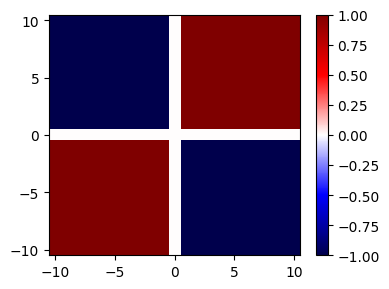

In [2]:
def compute_kernel_checkerboard_box(L):
    """Compute box-like checkerboard kernel [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L (int): Parameter specifying the kernel size 2*L+1

    Returns:
        kernel (np.ndarray): Kernel matrix of size (2*L+1) x (2*L+1)
    """
    axis = np.arange(-L, L+1)
    kernel = np.outer(np.sign(axis), np.sign(axis))
    return kernel

L = 10
kernel = compute_kernel_checkerboard_box(L)
plt.figure(figsize=(4,3))
plt.imshow(kernel, aspect='auto', origin='lower', 
           extent=[-L-0.5,L+0.5,-L-0.5,L+0.5], cmap='seismic')
plt.colorbar()
plt.tight_layout()

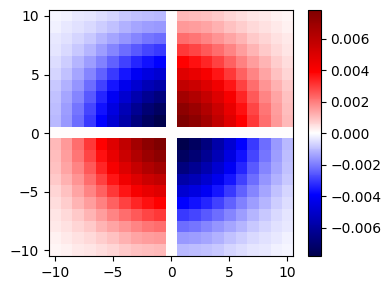

In [3]:
@jit(nopython=True)
def compute_kernel_checkerboard_gaussian(L, var=1, normalize=True):
    """Compute Guassian-like checkerboard kernel [FMP, Section 4.4.1].
    See also: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L (int): Parameter specifying the kernel size M=2*L+1
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 1.0)
        normalize (bool): Normalize kernel (Default value = True)

    Returns:
        kernel (np.ndarray): Kernel matrix of size M x M
    """
    taper = np.sqrt(1/2) / (L * var)
    axis = np.arange(-L, L+1)
    gaussian1D = np.exp(-taper**2 * (axis**2))
    gaussian2D = np.outer(gaussian1D, gaussian1D)
    kernel_box = np.outer(np.sign(axis), np.sign(axis))
    kernel = kernel_box * gaussian2D
    if normalize:
        kernel = kernel / np.sum(np.abs(kernel))
    return kernel

L = 10
var = 0.5
kernel = compute_kernel_checkerboard_gaussian(L, var)
plt.figure(figsize=(4,3))
plt.imshow(kernel, aspect='auto', origin='lower', 
           extent=[-L-0.5,L+0.5,-L-0.5,L+0.5], cmap='seismic')
plt.colorbar()
plt.tight_layout()

In [4]:
# @jit(nopython=True)
def compute_novelty_ssm(S, kernel=None, L=10, var=0.5, exclude=False):
    """Compute novelty function from SSM [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        S (np.ndarray): SSM
        kernel (np.ndarray): Checkerboard kernel (if kernel==None, it will be computed) (Default value = None)
        L (int): Parameter specifying the kernel size M=2*L+1 (Default value = 10)
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 0.5)
        exclude (bool): Sets the first L and last L values of novelty function to zero (Default value = False)

    Returns:
        nov (np.ndarray): Novelty function
    """
    if kernel is None:
        kernel = compute_kernel_checkerboard_gaussian(L=L, var=var)
    N = S.shape[0]
    M = 2*L + 1
    nov = np.zeros(N)
    # np.pad does not work with numba/jit
    S_padded = np.pad(S, L, mode='constant')

    for n in range(N):
        # Does not work with numba/jit
        nov[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)
    if exclude:
        right = np.min([L, N])
        left = np.max([0, N-L])
        nov[0:right] = 0
        nov[left:N] = 0

    return nov

L_kernel = 20
nov = compute_novelty_ssm(S, L=L_kernel, exclude=False)   
fig, ax, line = libfmp.b.plot_signal(nov, Fs = Fs_X, color='k')    

NameError: name 'S' is not defined

# UMAP dimensionality reduction

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import audio_processing
embedding = audio_processing.embed_data('../data', export=False)
print(embedding.shape)

/opt/homebrew/Caskroom/miniconda/base/envs/the-big-voice/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
def embed_data(data_folder='../data', user='all', export=False):
    '''
    Reduce dimensionality of the whole dataset of features
    '''
    import os
    from sklearn.manifold import TSNE
    from umap import UMAP
    import pandas as pd
    import numpy as np
    recordings = pd.read_csv(os.path.join(data_folder, 'recordings.csv'))#['recording_file'].tolist()
    if (user != 'all'): recordings = recordings[recordings['username'] == user]
    features = []
    items = []
    for idx in recordings.index: # loop over all recording files
        username = recordings['username'][idx]
        recording = recordings['recording_file'][idx] # with .wav extension
        data_file = os.path.join(data_folder, username, recording.rsplit('.', 1)[0], 'data.csv')
        df = pd.read_csv(data_file, header=0)
        features_i = df.iloc[:, 3:].values
        item = df.iloc[:, 0:3].values
        recording_col = np.array([[recording] for i in range(item.shape[0])])
        username_col = np.array([[username] for i in range(item.shape[0])])
        item = np.concatenate([recording_col, item], axis=1)
        item = np.concatenate([username_col, item], axis=1)
        if (np.size(features) == 0): features = features_i
        else: features = np.append(features, features_i, axis=0) # ndarray (num_seg, 64 feature dimensions)
        if (np.size(items) == 0): items = item
        else: items = np.append(items, item, axis=0)
    # features = np.array(features) # raw features
    # items = np.array(items) # ['username', 'audiofile', 'segment_index', 'start_time_sec', 'end_time_sec']
    # print(features.shape)

    # print(features.shape[0], items.shape[0])
    # umap_2d = UMAP(n_components=2, n_jobs=1, init='random', random_state=0)
    umap_2d = UMAP(n_jobs=1, metric='cosine', random_state=42, low_memory=True)
    features_embedded = umap_2d.fit_transform(features)
    # tsne = TSNE(n_components=2, learning_rate='auto', perplexity=30)
    # features_embedded = tsne.fit_transform(features)
    # print(features_embedded.shape)
    data_2d = np.append(items, features_embedded, axis=1)
    
    # save 2D coordinates
    
    columns = ['username', 'audiofile', 'segment_index', 'start_time_sec', 'end_time_sec', 'embedding_x', 'embedding_y']
    data_df = pd.DataFrame(data_2d, columns = columns)
    if not export: return data_df
    filepath = os.path.join(data_folder, 'coords_umap_user.csv')
    data_df.to_csv(filepath, mode='w', header=True, index=False)

In [18]:
df = embed_data(user='admin', export=True)

In [19]:
import pandas as pd
df = pd.read_csv('../data/coords_umap_user.csv', header=0)
embedding_umap = df.iloc[:, 5:].values #ndarray
embedding_umap.shape

(97, 2)

In [11]:
df = pd.read_csv('../data/coords_tsne.csv', header=0)
embedding_tsne = df.iloc[:, 5:].values #ndarray
data_dict = df.to_dict('records')
df[df['username'] == 'admin']

,username,audiofile,segment_index,start_time_sec,end_time_sec,tsne1,tsne2
214,admin,2024-07-28-16-46-00.wav,0.0,0.0,0.5,-3.425574,2.600461
215,admin,2024-07-28-16-46-00.wav,1.0,0.5,1.0,12.887788,-0.063499
216,admin,2024-07-28-16-46-00.wav,2.0,1.0,1.5,7.726603,0.124579
217,admin,2024-07-28-16-46-00.wav,3.0,1.5,2.0,4.657394,1.063623
218,admin,2024-07-28-16-46-00.wav,4.0,2.0,2.5,14.572329,-0.661732
...,...,...,...,...,...,...,...
270,admin,2024-09-10-15-28-47.wav,13.0,6.5,7.0,-8.994155,3.296722
271,admin,2024-09-10-15-28-47.wav,14.0,7.0,7.5,-6.887637,3.143312
272,admin,2024-09-10-15-28-47.wav,15.0,7.5,8.0,-8.669341,2.783830
273,admin,2024-09-10-15-28-47.wav,16.0,8.0,8.5,-9.254975,2.946698


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


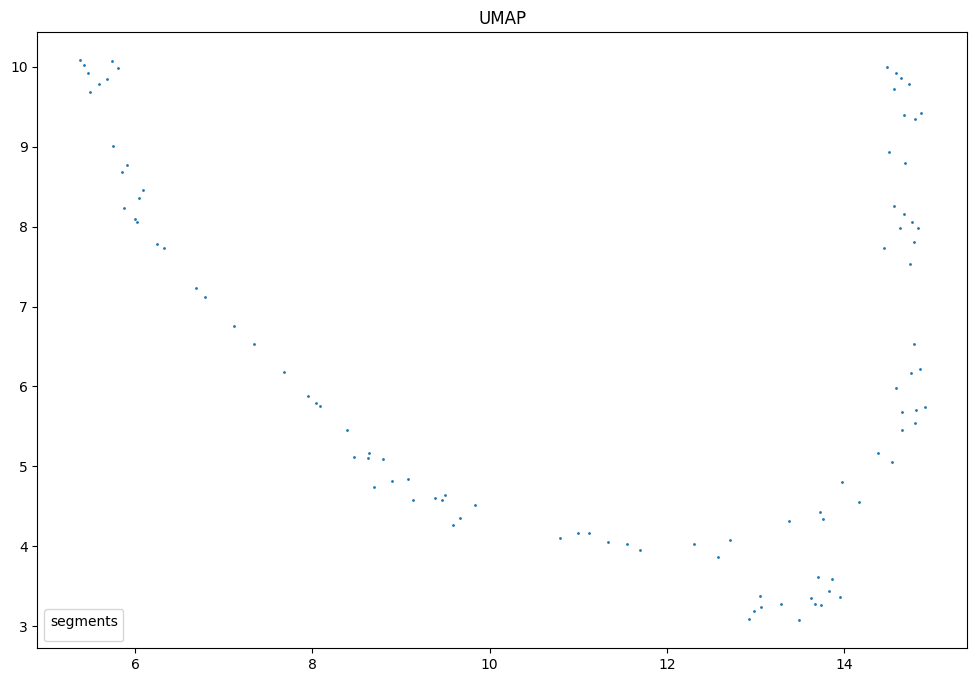

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], s=1)#, c=y_subset.astype(int), cmap='tab10')
plt.legend(*scatter.legend_elements(), title='segments')
plt.title('UMAP')
plt.show()

In [293]:
# Importing the audiofile
home_dir = '..'
audio_dir = os.path.join(home_dir, 'audio')
filename = "test2.wav"
filename_text = filename.rsplit('.', 1)[0].lower()
filepath = os.path.join(audio_dir, filename)

In [94]:
def load_audio_pydub(filepath):
    from pydub import AudioSegment
    file_text = filepath.rsplit('.', 1)[0].lower() # or file[:-3]
    file_extension = filepath.rsplit('.', 1)[1].lower() # or audiofile[-3:]
    if file_extension == "mp3":
        wav_audio = AudioSegment.from_mp3(filepath)
        filepath = file_text + "wav" # set new audio_path
        wav_audio.export(filepath, format="wav")
    sound = AudioSegment.from_file(filepath) #, format='wav')
    sound = sound.split_to_mono()[0]
    # Getting sample rate and sound_arr
    sr = sound.frame_rate
    duration = sound.duration_seconds
    sound_arr = np.divide(sound.get_array_of_samples(), sound.max_possible_amplitude)
    return sound_arr, sr, duration

def millisec2sample(size, sr=48000):
    return int(size*sr*1e-3)

In [95]:
# load with pydub
sound_arr, sr, duration = load_audio_pydub(filepath)
print(sr, duration, sound_arr.shape[-1])

48000 48.0 2304000


In [96]:
# # load with librosa
# sound_arr, sr = librosa.load(filepath, sr=48000)
# duration = sound_arr.shape[-1]/sr
# print(sound_arr.shape, sr, duration)

In [97]:
num_frames = int(np.ceil((sound_arr.shape[-1]-millisec2sample(SEGMENT_SIZE))/millisec2sample(SEGMENT_SIZE*HOPPING))+ 1) # use this format to calculate num frames
print(duration, num_frames)

48.0 96


In [158]:
spectral_args = {"n_fft":millisec2sample(SEGMENT_SIZE), "hop_length":millisec2sample(HOPPING*SEGMENT_SIZE), "center":False}
temporal_args = {"frame_length":millisec2sample(SEGMENT_SIZE), "hop_length":millisec2sample(HOPPING*SEGMENT_SIZE), "center":False}

stft = librosa.stft(y=sound_arr, **spectral_args)
sc = librosa.feature.spectral_centroid(y=sound_arr, sr=sr, **spectral_args)[0]
mfccs = librosa.feature.mfcc(y=sound_arr, sr=sr, **spectral_args)
sf = librosa.feature.spectral_flatness(y=sound_arr, **spectral_args)[0]
rms = librosa.feature.rms(y=sound_arr, **temporal_args)[0]
zcr = librosa.feature.zero_crossing_rate(y=sound_arr, **temporal_args)[0]

# if not {sc.shape[-1], mfccs.shape[-1], sf.shape[-1], rms.shape[-1], zcr.shape[-1]}=={sc.shape[-1]}:
# raise error

print(sc.shape, mfccs.shape, sf.shape, zcr.shape, rms.shape)
print(mfccs.T[0])

(96,) (20, 96) (96,) (96,) (96,)
[ 67.88500467 105.77621862 -16.15190688  42.97867662 -15.55531227
  16.2112126   -9.46398626   8.54567837  -9.51777657   4.75309865
  -3.48758112   5.9587811    1.27260624   0.13839723  -1.41568051
   1.22414337  -5.31567035  -3.11876917  -7.24505497  -5.55776289]


In [268]:
mfcc_delta = librosa.feature.delta(mfccs)
mfcc_delta2 = librosa.feature.delta(mfcc_delta)
print(mfcc_delta.shape, mfcc_delta2.shape)

(20, 96) (20, 96)


In [204]:
def save_data_csv(filename, data, data_dir='data', data_file='data.csv'):
    filename_text = filename.rsplit('.', 1)[0].lower()
    data_dir = os.path.join(data_dir, filename_text) 
    data_file = os.path.join(data_dir, data_file) # /data/<filename>/data.csv
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    data.to_csv(data_file, mode='w', header=True, index=False) # data_file name always unique

In [207]:
# def read_data_csv(filename, data, data_dir='data', data_file='data.csv'):


In [294]:
data = []
for i in range(sc.shape[-1]): # loop over num segments
    end_time = (i+1)*SEGMENT_SIZE*1e-3
    if end_time >= duration: end_time = duration
    data_i = [filename, i, i*SEGMENT_SIZE*1e-3, end_time, rms[i], zcr[i], sc[i], sf[i]]
    data_i.extend(mfccs.T[i].tolist() + mfcc_delta.T[i].tolist() + mfcc_delta2.T[i].tolist())
    data.append(data_i)

In [295]:
len(data[0])

68

In [296]:
columns = ['audiofile', 'segment_index', 'start_time_sec', 'end_time_sec', 'rms', 'zero_crossing_rate', 'spectral_centroid', 'spectral_flatness']
# mfcc_columns = [f'mfcc_{j+1}' for j in range(mfccs.shape[0])]
for j in range(mfccs.shape[0]):
    columns.append(f'mfcc_{j+1}')
for j in range(mfccs.shape[0]):
    columns.append(f'mfcc_delta_{j+1}')
for j in range(mfccs.shape[0]):
    columns.append(f'mfcc_delta2_{j+1}')
# print(columns)

data_df = pd.DataFrame(data, columns = columns)

In [297]:
data_df[-5:]

,audiofile,segment_index,start_time_sec,end_time_sec,rms,zero_crossing_rate,spectral_centroid,spectral_flatness,mfcc_1,mfcc_2,...,mfcc_delta2_11,mfcc_delta2_12,mfcc_delta2_13,mfcc_delta2_14,mfcc_delta2_15,mfcc_delta2_16,mfcc_delta2_17,mfcc_delta2_18,mfcc_delta2_19,mfcc_delta2_20
91,test2.wav,91,45.5,46.0,0.033646,0.124167,4739.554597,0.025649,65.291590,108.668286,...,0.148354,0.091751,0.037251,0.042803,0.043909,0.005092,-0.063569,-0.069808,-0.083574,-0.079041
92,test2.wav,92,46.0,46.5,0.030385,0.132042,5220.555695,0.036938,59.503713,98.612199,...,0.148354,0.091751,0.037251,0.042803,0.043909,0.005092,-0.063569,-0.069808,-0.083574,-0.079041
93,test2.wav,93,46.5,47.0,0.036336,0.114458,4994.541990,0.031651,60.565724,104.819437,...,0.148354,0.091751,0.037251,0.042803,0.043909,0.005092,-0.063569,-0.069808,-0.083574,-0.079041
94,test2.wav,94,47.0,47.5,0.031793,0.127125,5242.887599,0.033465,54.841087,97.261728,...,0.148354,0.091751,0.037251,0.042803,0.043909,0.005092,-0.063569,-0.069808,-0.083574,-0.079041
95,test2.wav,95,47.5,48.0,0.031991,0.125333,4988.771548,0.033255,59.867296,102.217294,...,0.148354,0.091751,0.037251,0.042803,0.043909,0.005092,-0.063569,-0.069808,-0.083574,-0.079041


In [298]:
save_data_csv(filename, data_df, '../data')

In [299]:
datafile = '../data/test2/data.csv'
features = pd.read_csv(datafile, header=0).iloc[:, 4:].values #ndarray
features.shape # [num data points, feature dimensions]

(96, 64)

In [256]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto', perplexity=20)
features_embedded = tsne.fit_transform(features)
features_embedded.shape

(96, 2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


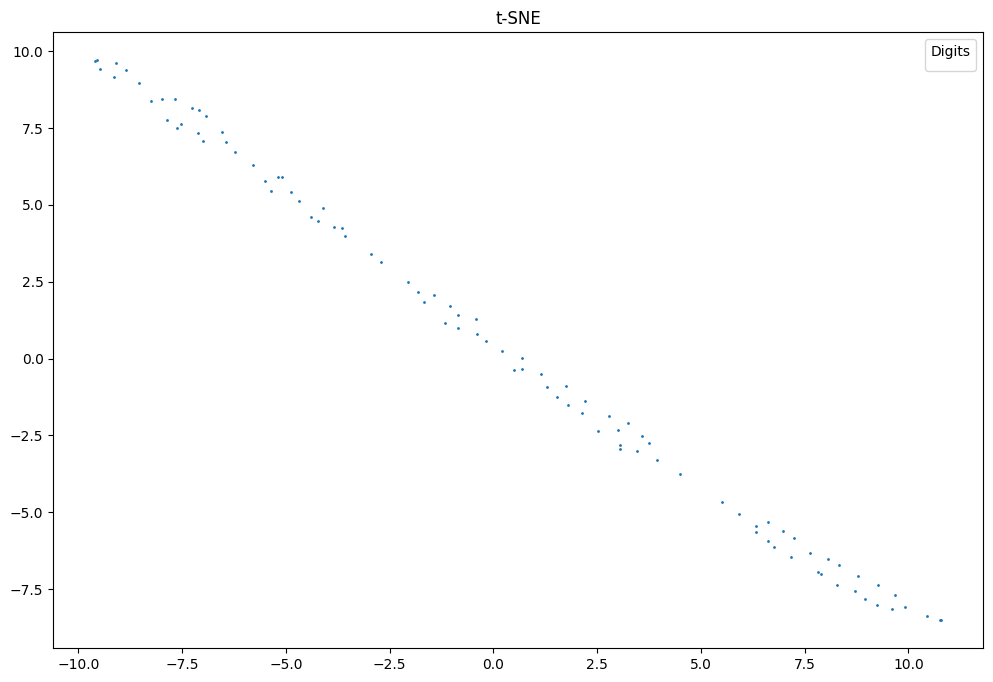

In [257]:
# Plot the result
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_embedded[:, 0], features_embedded[:, 1], s=1)#, c=y_subset.astype(int), cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title('t-SNE')
plt.show()

# Plot tests

[Text(0.5, 1.0, 'MFCC')]

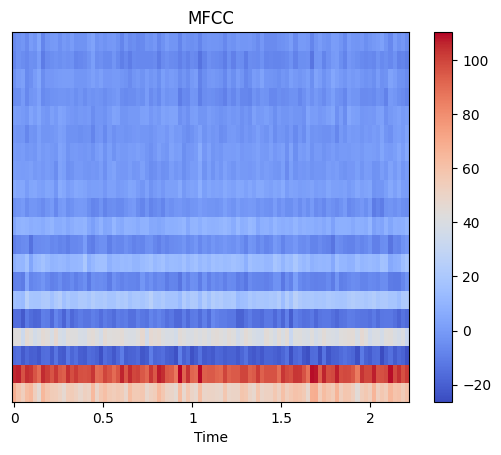

In [101]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()#(nrows=2, sharex=True)
# img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                            #    x_axis='time', y_axis='mel', fmax=8000,
                            #    ax=ax[0])
# fig.colorbar(img, ax=[ax[0]])
# ax[0].set(title='Mel spectrogram')
# ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=[ax])
ax.set(title='MFCC')

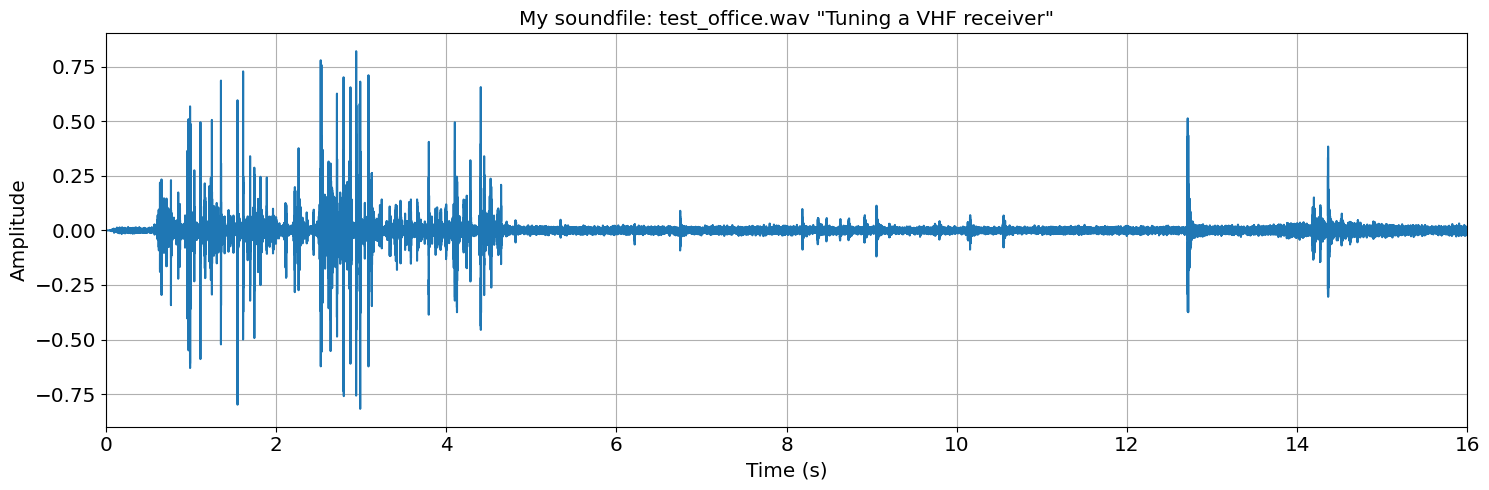

In [77]:
# The following makes the plot look nice
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig, ax = plt.subplots()
plt.plot(np.arange(len(sound_arr))/sr, sound_arr)
ax.set_title('My soundfile: test_office.wav "Tuning a VHF receiver"')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time (s)')
ax.set_xlim(left=0,right=duration)
fig.tight_layout()
plt.grid()

3. Write a function that will take in the sound_arr of an audio file, a frame size in samples, a hop size in sound_arr, and a sampling rate, and compute and return the spectral centroid of each frame. The spectral centroid of a rectangular window of audio $x[n]$ of length $N$ (even) is defined as 
$$ R_{0.5}(x) = \frac{\sum_{k=0}^{N/2+1} \frac{F_s k}{N} |X[k]|}{\sum_{k=0}^{N/2+1} |X[k]|} $$
where $X[k]$ is the DFT of $x[n]$, and $F_s$ is the sampling rate.

In [88]:
def calculate_frame_num(num_sample, sr, SEGMENT_SIZE, HOPPING):
    SEGMENT_SIZE = int(SEGMENT_SIZE * sr * 1e-3)
    hop_size = int(HOPPING * SEGMENT_SIZE)
    return int(np.ceil(num_sample-SEGMENT_SIZE)/hop_size) + 1

In [24]:
# add your code below
def extractSpectralCentroid(samples, sr, SEGMENT_SIZE, hop_size):
    # import math
    num_frames = calculate_frame_num(len(samples), sr, SEGMENT_SIZE, hop_size) #number of frames
    spectral_centroids = []
    
    for i in range(num_frames):
        current_frame = samples[i*hop_size: i*hop_size+SEGMENT_SIZE]
        N = len(current_frame)
        fft_frame = np.abs(fft(current_frame))[0:((N//2)+1)]
        numerator_factors = []
        for k in range(len(fft_frame)):
            numerator_factors.append((sr*k*fft_frame[k])//N)
            
        numerator = np.sum(numerator_factors)
        denominator = np.sum(fft_frame)
        
        spectral_centroids.append(numerator//denominator)
        
    return spectral_centroids

4. Using your function, compute spectral centroid features for contiguous 46 ms frames hopped 50% for the audio file you used in part 1. (Ignore any frames at the end of audio files that are less than that length.) Plot the first 10 seconds of your time domain waveform, and plot the series of spectral centroids you extracted.

96


(0.0, 10.0)

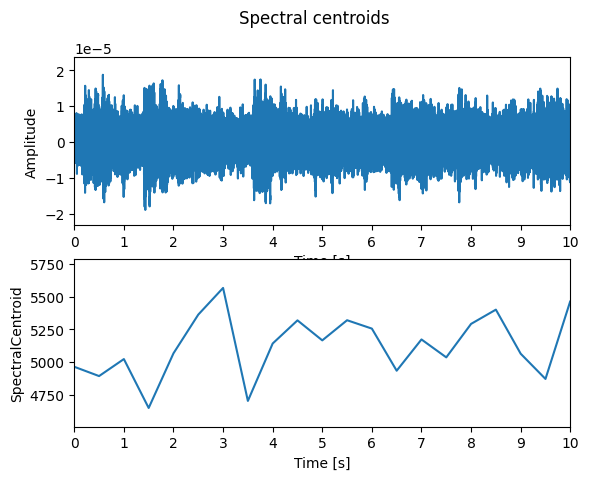

In [26]:
# add your code below
spectral_centroids = extractSpectralCentroid(sound_arr, sr, SEGMENT_SIZE, HOPPING)
print(len(spectral_centroids))

fig_, ax = plt.subplots(2)
fig_.suptitle('Spectral centroids')

# subplot: waveform
y = [sound_arr[i]/10000.0 for i in range(len(sound_arr))]
xticks = [sr*i for i in range(11)]
ax[0].plot(y)
# ax[0].set_title('Time domain waveform in 10 seconds')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Amplitude')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([i for i in range(11)])
ax[0].set_xlim([0, 10*sr])
# subplot: spectral centroids with framing
time = [ round( 1e-3* i* HOPPING*SEGMENT_SIZE, 3 ) for i in range(len(spectral_centroids)) ]
ax[1].plot(time, spectral_centroids)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('SpectralCentroid')
ax[1].set_xticks([i for i in range(11)])
ax[1].set_xlim([0, 10])

In [103]:
def RMS(samples, sr, frame_size, hop_size):
    num_frames = calculate_frame_num(len(samples), sr, SEGMENT_SIZE, hop_size) #number of frames
    rms = []

    for i in range(num_frames):
        current_frame = samples[i*hop_size: i*hop_size+frame_size]
        rms.append(np.sqrt(np.mean(current_frame**2)))
    
    return rms

(0.0, 10.0)

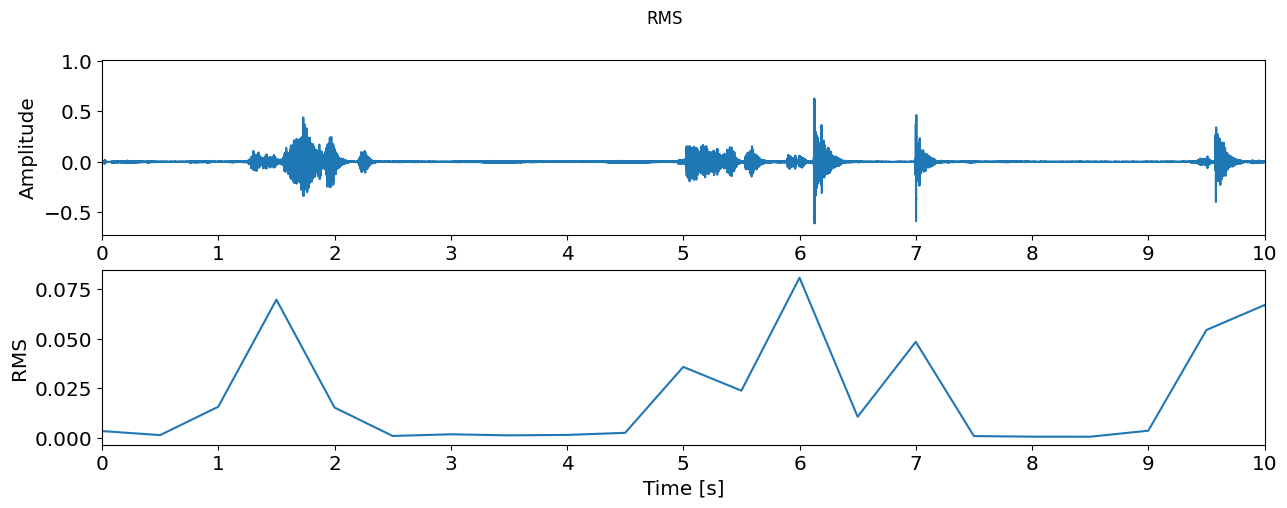

In [104]:
rms = RMS(sound_arr, sr, SEGMENT_SIZE, HOPPING)

fig_, ax = plt.subplots(2)
fig_.suptitle('RMS')
# subplot: waveform
y = [sound_arr[i] for i in range(len(sound_arr))]
xticks = [sr*i for i in range(11)]
ax[0].plot(y)
# ax[0].set_title('Time domain waveform in 10 seconds')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Amplitude')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([i for i in range(11)])
ax[0].set_xlim([0, 10*sr])
# subplot: spectral centroids with framing
time = [ round( 1e-3* i* HOPPING*SEGMENT_SIZE, 3 ) for i in range(len(rms)) ]
ax[1].plot(time, rms)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('RMS')
ax[1].set_xticks([i for i in range(11)])
ax[1].set_xlim([0, 10])

In [105]:
def normalizeFeature(x):
    x = np.asarray(x)
    x = np.divide(x, np.absolute(x).max())
    return x.tolist()

In [106]:
spectral_centroids = normalizeFeature(spectral_centroids)
rms = normalizeFeature(rms)

In [107]:
# [filename, chunk number (file sub index), start time, end time, spec centroid, rms]

# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
# UPLOAD_FOLDER = os.path.join(BASE_DIR, 'uploads')
# data_dir = os.path.join(BASE_DIR, 'data')

filename_text = filename.rsplit('.', 1)[0].lower()
filename_extension = filename.rsplit('.', 1)[1].lower()

data_dir = os.path.join('../data', filename_text)
data_file = 'data.csv'
data_file = os.path.join(data_dir, data_file)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
print(data_file)

../data/recording/data.csv


In [99]:
def save_to_csv(df, file_name, header=True):
    # Check if the file already exists
    if os.path.isfile(file_name):
        # If it exists, append without writing the header
        df.to_csv(file_name, mode='a', header=False, index=False)
    else:
        # If it does not exist, create the file with the header
        df.to_csv(file_name, mode='w', header=header, index=False)

In [100]:
data = []
# for the same audio file
for i in range(num_frames):
    data.append([filename, i, i*SEGMENT_SIZE*1e-3, (i+1)*SEGMENT_SIZE*1e-3, spectral_centroids[i], rms[i]])
    # print(i, data[i])

df = pd.DataFrame(data, columns = ['filename', 'chunk index', 'start time sec', 'end time sec', 'centroid', 'rms'])
print(df[-3:])

save_to_csv(df, data_file)

         filename  chunk index  start time sec  end time sec  centroid  \
21  recording.wav           21            10.5          11.0  0.537064   
22  recording.wav           22            11.0          11.5  0.728561   
23  recording.wav           23            11.5          12.0  0.751453   

         rms  
21  0.121189  
22  0.096984  
23  0.092347  


In [18]:
import pandas as pd
filename = '../data/test_office/data.csv'
data = pd.read_csv(filename, header=0)
feed_data = data.values.tolist()
print(type([1,2,3]))
print(type(feed_data))
print(feed_data[0], '\n', len(feed_data))

<class 'list'>
<class 'list'>
['test_office.wav', 0, 0.0, 0.5, 0.5050872093023255, 0.0707144135259617] 
 64
